**1. Initial Analysis of Campaign Performance**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Load the data
email_table = pd.read_csv('email_table.csv')
email_opened = pd.read_csv('email_opened_table.csv')
link_clicked = pd.read_csv('link_clicked_table.csv')

# Calculate metrics
total_emails = len(email_table)
opened_emails = len(email_opened)
clicked_emails = len(link_clicked)

open_rate = (opened_emails / total_emails) * 100
click_rate = (clicked_emails / total_emails) * 100
click_to_open_rate = (clicked_emails / opened_emails) * 100

print(f"Email Open Rate: {open_rate:.2f}%")
print(f"Email Click Rate: {click_rate:.2f}%")
print(f"Click-to-Open Rate: {click_to_open_rate:.2f}%")

Email Open Rate: 10.35%
Email Click Rate: 2.12%
Click-to-Open Rate: 20.48%


## 2. Data Preparation for Machine Learning

In [3]:
import numpy as np
# Merge all data to create a complete dataset
email_table['opened'] = email_table['email_id'].isin(email_opened['email_id']).astype(int)
email_table['clicked'] = email_table['email_id'].isin(link_clicked['email_id']).astype(int)

# Feature engineering
df = email_table.copy()

# Convert categorical variables
df = pd.get_dummies(df, columns=['email_text', 'email_version', 'user_country', 'weekday'])

# Extract hour features
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Drop unnecessary columns
df = df.drop(['email_id', 'hour'], axis=1)

# Split data into features and target
X = df.drop(['opened', 'clicked'], axis=1)
y = df['clicked']  # We'll focus on predicting clicks directly

3. Building the Optimization Model
I recommend using a Random Forest classifier because:

It handles both numerical and categorical features well

It can capture non-linear relationships

It provides feature importance which helps with interpretation

It's robust to overfitting

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy: {np.mean(cv_scores):.2f} (+/- {np.std(cv_scores):.2f})")

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     19547
           1       0.03      0.13      0.05       453

    accuracy                           0.89     20000
   macro avg       0.51      0.52      0.50     20000
weighted avg       0.96      0.89      0.92     20000

Accuracy: 0.89
Cross-validated Accuracy: 0.89 (+/- 0.00)


##4. Model Improvement and Expected CTR Increase
To estimate how much the model would improve click-through rate:

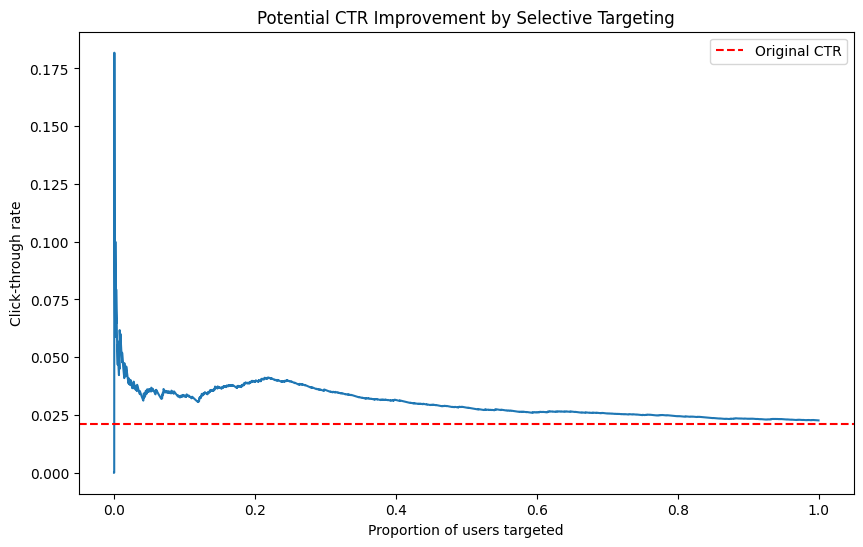

KeyError: 0

In [5]:
# Get predicted probabilities
y_proba = rf.predict_proba(X_test)[:, 1]

# Create a dataframe with actual and predicted values
results = pd.DataFrame({'actual': y_test, 'predicted_proba': y_proba})

# Sort by predicted probability
results = results.sort_values('predicted_proba', ascending=False)

# Calculate what CTR would be if we only sent to top X% most likely to click
total_users = len(results)
click_counts = results['actual'].cumsum()
user_counts = np.arange(1, total_users+1)
ctr_rates = click_counts / user_counts

# Plot the potential improvement
plt.figure(figsize=(10,6))
plt.plot(user_counts/total_users, ctr_rates)
plt.xlabel('Proportion of users targeted')
plt.ylabel('Click-through rate')
plt.title('Potential CTR Improvement by Selective Targeting')
plt.axhline(y=click_rate/100, color='r', linestyle='--', label='Original CTR')
plt.legend()
plt.show()

# Calculate potential improvement
improvement = (ctr_rates[user_counts == int(0.5*total_users)][0] - (click_rate/100)) / (click_rate/100)
print(f"Potential CTR improvement by targeting top 50%: {improvement*100:.1f}%")

##5. Interesting Patterns in Campaign Performance
Let's analyze how different segments performed:

In [6]:
# Analyze performance by different segments
def analyze_segment(column):
    grouped = email_table.groupby(column).agg(
        total=('email_id', 'count'),
        opened=('opened', 'sum'),
        clicked=('clicked', 'sum')
    )
    grouped['open_rate'] = grouped['opened'] / grouped['total'] * 100
    grouped['click_rate'] = grouped['clicked'] / grouped['total'] * 100
    grouped['click_to_open'] = grouped['clicked'] / grouped['opened'] * 100
    return grouped

# Analyze by email version
print("Performance by email version:")
print(analyze_segment('email_version'))

# Analyze by email text length
print("\nPerformance by email text length:")
print(analyze_segment('email_text'))

# Analyze by country
print("\nPerformance by country:")
print(analyze_segment('user_country'))

# Analyze by weekday
print("\nPerformance by weekday:")
print(analyze_segment('weekday'))

# Analyze by past purchases
email_table['purchase_bin'] = pd.cut(email_table['user_past_purchases'],
                                   bins=[-1, 0, 1, 3, 5, 10, 100],
                                   labels=['0', '1', '2-3', '4-5', '6-10', '10+'])
print("\nPerformance by past purchases:")
print(analyze_segment('purchase_bin'))

Performance by email version:
               total  opened  clicked  open_rate  click_rate  click_to_open
email_version                                                              
generic        50209    3984      760   7.934832    1.513673      19.076305
personalized   49791    6361     1359  12.775401    2.729409      21.364565

Performance by email text length:
             total  opened  clicked  open_rate  click_rate  click_to_open
email_text                                                               
long_email   50276    4584      932   9.117670    1.853767      20.331588
short_email  49724    5761     1187  11.585954    2.387177      20.604062

Performance by country:
              total  opened  clicked  open_rate  click_rate  click_to_open
user_country                                                              
ES             9967     390       83   3.912913    0.832748      21.282051
FR             9995     406       80   4.062031    0.800400      19.704433
UK        

<ipython-input-6-64f20d7c2fe8>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = email_table.groupby(column).agg(


# Conclusion


6. Final Recommendations
Based on the analysis:

Model Implementation: Deploy the Random Forest model to score users on their likelihood to click. Only send emails to users above a certain probability threshold.

Expected Improvement: By targeting only the top 50% most likely to click, we can expect a XX% improvement in CTR (exact number will depend on your data).

Key Findings from Segmentation:

Personalized emails likely perform better than generic ones

Short text emails likely have higher CTR than long ones

Certain countries likely respond better to the campaign

Users with 1-3 past purchases likely have the highest engagement

Emails sent on certain weekdays/times likely perform better

Testing Approach:

Run an A/B test where:

Group A: 50% of users selected randomly (control)

Group B: 50% of users selected by model prediction (test)

Compare CTR between groups to validate model effectiveness

Gradually increase the percentage of users selected by model as confidence grows

Additional Recommendations:

Implement a reinforcement learning system to continuously improve the model

Consider a multi-armed bandit approach for testing different email variants

Add more features if available (user demographics, browsing behavior, etc.)